In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import tensorflow.keras.layers 
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression

In [3]:
data = pd.read_csv('water_potability.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


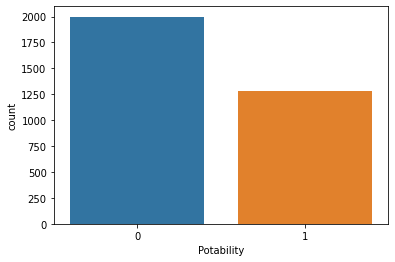

In [4]:
sns.countplot(data['Potability'])

In [5]:
print(f"Total No. Of Data Points :- {len(data)}")
data.describe()

Total No. Of Data Points :- 3276


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


**Replacing NAN's with median of each feature, beacause mean would result in outliers**

In [6]:
df1 = data[data['Potability'] == 1].copy()
df2 = data[data['Potability'] == 0].copy()
df1['ph'] = df1['ph'].replace(np.nan, df1['ph'].median())
df2['ph'] = df2['ph'].replace(np.nan, df2['ph'].median())
df1['Sulfate'] = df1['Sulfate'].replace(np.nan, df1['Sulfate'].median())
df2['Sulfate'] = df2['Sulfate'].replace(np.nan, df2['Sulfate'].median())
df1['Trihalomethanes'] = df1['Trihalomethanes'].replace(np.nan, df1['Trihalomethanes'].median())
df2['Trihalomethanes'] = df2['Trihalomethanes'].replace(np.nan, df2['Trihalomethanes'].median())
data1 = pd.concat([df1,df2], axis  =0, ignore_index = True)

**Segregating water into different types based on PH Value and adding them as new features**

In [7]:
data1['ph'] = data1['ph'].round(decimals = 1)

def water_type(x):
    if x > 8:
        y = 'Alkaline'
    elif x <= 8 and x > 7.5:
        y = 'Seawater'
    elif x == 7.5:
        y = 'Tap'
    elif x < 7.5 and x >= 6.5:
        y = 'Bottled'
    elif x < 6.5 and x >= 5.5:
        y = 'Distilled'
    else:
        y = 'Acidic'
        
    return y
        
data1['Type'] = data1['ph'].apply(lambda x: water_type(x))

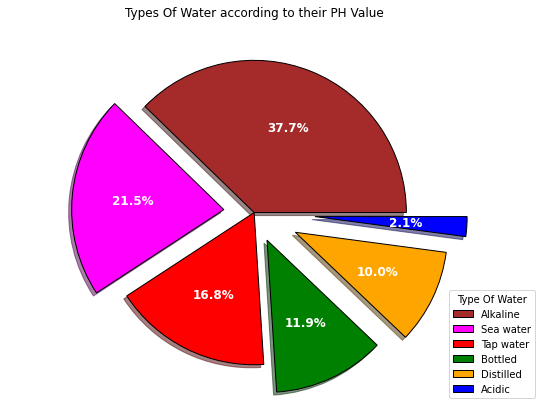

In [8]:
dat = data1['Type'].value_counts()
explode = (0.0, 0.2, 0.0, 0.2, 0.3,0.4)
colors = ('brown','magenta','red','green','orange','blue')
lebs = ['Alkaline','Sea water','Tap water','Bottled','Distilled','Acidic']
wp = {'linewidth' : 1, 'edgecolor' : "black"}
fig, ax = plt.subplots(figsize =(10,7))
wd, texts, txt = ax.pie(dat.values, autopct = '%1.1f%%', explode = explode, labels = lebs, shadow = True, colors = colors, wedgeprops = wp, textprops = dict(color = "white"))
ax.legend(wd, lebs, title = "Type Of Water", loc = "lower left", bbox_to_anchor = (1,0,0.5,1))
plt.setp(txt, size = 12, weight ="bold")
ax.set_title("Types Of Water according to their PH Value")
plt.show()

**Determining Type Of Hardness of a given water sample based on Hardness Index**

In [9]:
def hard_type(x):

    if x >= 0 and x < 17.1:
        y = 'Soft'

    elif x >= 17.1 and x < 120:
        y = 'Medium hard'

    elif x >= 120 and x < 180:
        y = 'Hard'
        
    else:
        y = 'Very hard'

    return y
        
data1['Hard_type'] = data1['Hardness'].apply(lambda x: hard_type(x))

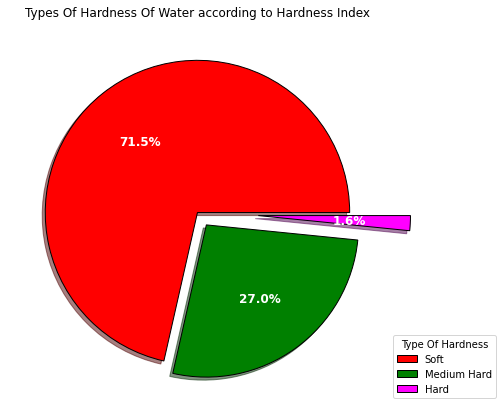

In [10]:
dat = data1['Hard_type'].value_counts()
explode = (0.0, 0.1, 0.4)
colors = ('red','green','magenta')
lebs = ['Soft','Medium Hard','Hard']
wp = {'linewidth' : 1, 'edgecolor' : "black"}
fig, ax = plt.subplots(figsize =(10,7))
wd, texts, txt = ax.pie(dat.values, autopct = '%1.1f%%', explode = explode, labels = lebs, shadow = True, colors = colors, wedgeprops = wp, textprops = dict(color = "white"))
ax.legend(wd, lebs, title = "Type Of Hardness", loc = "lower left", bbox_to_anchor = (1,0,0.5,1))
plt.setp(txt, size = 12, weight ="bold")
ax.set_title("Types Of Hardness Of Water according to Hardness Index")
plt.show()

In [11]:
data1.drop('Type',axis = 1,inplace = True)
data1.drop('Hard_type',axis = 1,inplace = True)

**Determining the quality of water based on its total dissolved solids in (ppm)**

In [12]:
def tds_type(x):

    if x < 300:
        y = 'Excellent'

    elif x >= 300 and x < 600:
        y = 'Good'

    elif x >= 600 and x < 900:
        y = 'Fair'
    elif x >= 900 and x < 1200:
        y = 'Poor'
    else:
        y = 'Unacceptable'

    return y
        
data1['TDS'] = data1['Solids'].apply(lambda x: hard_type(x))

In [13]:
data1.drop('TDS',axis = 1,inplace = True)

Splitting Data into **Training Data** and **Test Data**.

In [14]:
dat = data1.values
X = dat[:,np.array([x for x in range(len(data1.columns) - 1)])]
Y = dat[:,-1]
x_trn, x_tst, y_trn, y_tst = train_test_split(X,Y, train_size = 0.75, random_state = 83)
scl = StandardScaler()
x_trn1 = scl.fit_transform(x_trn)
x_tst1 = scl.transform(x_tst)

Prediction Using **DECISION TREE CLASSIFIER**

In [15]:
clf = DecisionTreeClassifier()
clf.fit(x_trn1,y_trn)

DecisionTreeClassifier()

In [16]:
print(f"Training Score :- {clf.score(x_trn1,y_trn)}")
print(f"Testing Score :- {clf.score(x_tst1,y_tst)}")

Training Score :- 1.0
Testing Score :- 0.6800976800976801


There is a lot of **Overfitting** if we apply **Decision Tree Classifier** as the training score is 100% while the test score is only 66.8 % 

Prediction using **RANDOM FOREST CLASSIFIER**

In [17]:
clf2 = RandomForestClassifier(max_depth = 1, random_state = 1)
clf2.fit(x_trn1,y_trn)
print(f"Training Score :- {clf2.score(x_trn1,y_trn)}")
print(f"Testing Score :- {clf2.score(x_tst1,y_tst)}")

Training Score :- 0.6031746031746031
Testing Score :- 0.63003663003663


Prediction using **SUPPORT VECTOR CLASSIFIER**

In [18]:
y_trn_pred = clf2.predict(x_trn1)
y_tst_pred = clf2.predict(x_tst1)

In [19]:
from sklearn import svm
clf3 = svm.SVC()
clf3.fit(x_trn1,y_trn)
print(f"Training Score :- {clf3.score(x_trn1,y_trn)}")
print(f"Testing Score :- {clf3.score(x_tst1,y_tst)}")

Training Score :- 0.7326007326007326
Testing Score :- 0.7032967032967034


**Resulting Metrics For Training Data**

In [20]:
print(confusion_matrix(y_trn,y_trn_pred))

[[1482    0]
 [ 975    0]]


In [21]:
print(classification_report(y_trn,y_trn_pred))

              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75      1482
         1.0       0.00      0.00      0.00       975

    accuracy                           0.60      2457
   macro avg       0.30      0.50      0.38      2457
weighted avg       0.36      0.60      0.45      2457



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Result Metrics for Test Data**

In [22]:
print(confusion_matrix(y_tst,y_tst_pred))

[[516   0]
 [303   0]]


**Predictions**

In [23]:
for i in range(len(y_tst_pred)):
  if y_tst_pred[i] == 0:
    if x_tst[i,2] < 500:
      print(f"Total Dissolved Solids are {round(500 - x_tst[i,2],3)} mg/L LESS than the permissible limit")

    elif x_tst[i,2] > 1000:
      print(f"Total Dissolved Solids are {round(x_tst[i,2] - 1000,3)} mg/L MORE than the permissible limit")

    if x_tst[i,3] > 4:
      print(f"CHOLOROAMINES are {round(x_tst[i,3] - 4,3)} ppm MORE than the permissible limit")

    if x_tst[i,4] > 500:
      print(f"SULFATES are {round(x_tst[i,4] - 500,3)} mg/L MORE than the permissible limit")

    if x_tst[i,7] > 80:
      print(f"TRIHALOMETHANES are {round(x_tst[i,7] - 80,3)} ppm MORE than the permissible limit")

    print("Not Potable\n")

  else:
    print("Potable\n")

Total Dissolved Solids are 30101.684 mg/L MORE than the permissible limit
Not Potable

Total Dissolved Solids are 37413.057 mg/L MORE than the permissible limit
CHOLOROAMINES are 3.634 ppm MORE than the permissible limit
Not Potable

Total Dissolved Solids are 19574.364 mg/L MORE than the permissible limit
CHOLOROAMINES are 3.089 ppm MORE than the permissible limit
Not Potable

Total Dissolved Solids are 23211.631 mg/L MORE than the permissible limit
CHOLOROAMINES are 5.363 ppm MORE than the permissible limit
Not Potable

Total Dissolved Solids are 19868.628 mg/L MORE than the permissible limit
CHOLOROAMINES are 2.963 ppm MORE than the permissible limit
Not Potable

Total Dissolved Solids are 23470.204 mg/L MORE than the permissible limit
CHOLOROAMINES are 3.631 ppm MORE than the permissible limit
TRIHALOMETHANES are 0.652 ppm MORE than the permissible limit
Not Potable

Total Dissolved Solids are 19311.402 mg/L MORE than the permissible limit
CHOLOROAMINES are 2.791 ppm MORE than the 